<a href="https://colab.research.google.com/github/heldenwelt/Blocky_Testing/blob/main/OHBM_2023_Elisabeth_Kopie_von_neuroAI_dupre_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🚀 Set-up colab environment

First, we'll set up our colab run-time and install relevant dependencies

In [ ]:
!pip install nilearn
!pip install https://github.com/Parietal-INRIA/fmralign/archive/master.zip
!pip install git+https://github.com/ahwillia/netrep@0f3d825

  Using cached https://github.com/Parietal-INRIA/fmralign/archive/master.zip
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/ahwillia/netrep (to revision 0f3d825) to /tmp/pip-req-build-yqibpu8z
  Running command git clone --filter=blob:none --quiet https://github.com/ahwillia/netrep /tmp/pip-req-build-yqibpu8z
  Running command git checkout -q 0f3d825
  Resolved https://github.com/ahwillia/netrep to commit 0f3d825
  Preparing metadata (setup.py) ... done


In [ ]:
!wget osf.io/download/5fc7d0714269db010c1c62ca -O left_language_mask_3mm.nii.gz

URL transformed to HTTPS due to an HSTS policy
--2023-07-22 03:11:45--  https://osf.io/download/5fc7d0714269db010c1c62ca
Resolving osf.io (osf.io)... 35.190.84.173
Connecting to osf.io (osf.io)|35.190.84.173|:443... connected.
HTTP request sent, awaiting response... 308 PERMANENT REDIRECT
Location: https://osf.io/download/5fc7d0714269db010c1c62ca/ [following]
--2023-07-22 03:11:47--  https://osf.io/download/5fc7d0714269db010c1c62ca/
Reusing existing connection to osf.io:443.
HTTP request sent, awaiting response... 302 FOUND
Location: https://files.de-1.osf.io/v1/resources/6ysra/providers/osfstorage/5fc7d0714269db010c1c62ca [following]
--2023-07-22 03:11:47--  https://files.de-1.osf.io/v1/resources/6ysra/providers/osfstorage/5fc7d0714269db010c1c62ca
Resolving files.de-1.osf.io (files.de-1.osf.io)... 35.186.249.111
Connecting to files.de-1.osf.io (files.de-1.osf.io)|35.186.249.111|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://storage.googleapis.co

In [ ]:
import fmralign
from nilearn import plotting
from nilearn.maskers import NiftiMasker

from netrep.metrics import LinearMetric
from sklearn.model_selection import cross_validate

from fmralign.metrics import score_voxelwise
from fmralign.pairwise_alignment import PairwiseAlignment
from fmralign.fetch_example_data import fetch_ibc_subjects_contrasts

# 🧠 Accessing Individual Brain Charting (IBC) data

In this notebook, we'll use example data from the [Individual Brain Charting (IBC)](https://project.inria.fr/IBC/) project, distributed with `fmralign`.
Specifically, for the first two subjects, we'll fetch 53 unique contrast maps for a variety of cognitive tasks in the ARCHI and HCP cognitive batteries.
Each task was acquired in both the anterior-posterior (AP) and posterior-anterior (PA) phase encoding direction.
So, we can use contrast maps derived from the AP phase encoding direction to train alignments, and contrast maps from the PA phase encoding direction to test the learned alignments.

In [ ]:
files, df, mask = fetch_ibc_subjects_contrasts(
    ['sub-01', 'sub-02'])
masker = NiftiMasker(mask_img=mask).fit()

In [ ]:
source_train = df.query('subject=="sub-01" & acquisition=="ap" ')
source_train

,Unnamed: 0,subject,task,condition,acquisition,path
0,0,sub-01,archi_standard,audio_left_button_press,ap,/root/nilearn_data/ibc/sub-01/audio_left_butto...
2,2,sub-01,archi_standard,audio_right_button_press,ap,/root/nilearn_data/ibc/sub-01/audio_right_butt...
4,4,sub-01,archi_standard,video_left_button_press,ap,/root/nilearn_data/ibc/sub-01/video_left_butto...
6,6,sub-01,archi_standard,video_right_button_press,ap,/root/nilearn_data/ibc/sub-01/video_right_butt...
8,8,sub-01,archi_standard,horizontal_checkerboard,ap,/root/nilearn_data/ibc/sub-01/horizontal_check...
10,10,sub-01,archi_standard,vertical_checkerboard,ap,/root/nilearn_data/ibc/sub-01/vertical_checker...
12,12,sub-01,archi_standard,audio_sentence,ap,/root/nilearn_data/ibc/sub-01/audio_sentence_a...
14,14,sub-01,archi_standard,video_sentence,ap,/root/nilearn_data/ibc/sub-01/video_sentence_a...
16,16,sub-01,archi_standard,audio_computation,ap,/root/nilearn_data/ibc/sub-01/audio_computatio...
18,18,sub-01,archi_standard,video_computation,ap,/root/nilearn_data/ibc/sub-01/video_computatio...


In [ ]:
source_train = source_train.path.values
target_train = df.query('subject=="sub-02" & acquisition=="ap" ').path.values

# The testing fold:
# * source test: PA contrasts for subject sub-01, used to predict
#   the corresponding contrasts of subject sub-02
# * target test: PA contrasts for subject sub-02, used as a ground truth
#   to score our predictions
source_test = df.query('subject=="sub-01" & acquisition=="pa" ').path.values
target_test = df.query('subject=="sub-02" & acquisition=="pa" ').path.values

# 🤖 Compare representations between two individuals with CCA

Using the `netrep` package from the [NeuroStatsLab](http://neurostatslab.org/), we can derive distances between our two subjects.

To minimize compute, we'll take only the first two images from our training set within a defined left-lateralized language region-of-interest.
We can then compute shape distances using `LinearMetric`.
When $α = 0$, we use Canonical Correlation Analysis (CCA), where the group of allowed nuissance transformations is any arbitrary linear map.

First we fit alignment transformations to find the maximal correspondence within this group of transforms. Then, we evaluate the distance in the aligned space. These are respectively done by calling fit(...) and score(...) functions on the metric instance.

In [ ]:
lang_masker = NiftiMasker(mask_img='left_language_mask_3mm.nii.gz').fit()

cca_metric = LinearMetric(
    alpha=0.0,
    center_columns=True,
    score_method="angular",
    )

cca_metric.fit(lang_masker.transform(source_train[0]),
               lang_masker.transform(target_train[0]))
dist = cca_metric.score(lang_masker.transform(source_train[1]),
                        lang_masker.transform(target_train[1]))
dist

1.5967504956793495

# 🔀 Generate and apply Procrustes alignment transformations

Next, we can use the `PairwiseAlignment` class from `fmralign` to generate a functional alignment from sub-01 to sub-02.
We will learn this alignment using the AP contrasts from both subjects.
Specifically, we'll learn a Procrustes alignment in 150 non-overlapping parcels.
We can then apply the learnt alignments in the same parcels in held-out testing data : in our case, the PA contrasts.

In [ ]:
# First, we calculate the correlation of the PA data from sub-01 with the PA
# data of 2ub-02 using the score_voxelwise function
baseline_score = masker.inverse_transform(score_voxelwise(
    target_test, source_test, masker, loss='corr'))

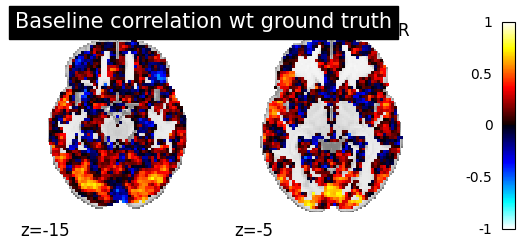

In [ ]:
baseline_display = plotting.plot_stat_map(
    baseline_score, display_mode="z", vmax=1, cut_coords=[-15, -5])
baseline_display.title("Baseline correlation wt ground truth")

In [ ]:
alignment_estimator = PairwiseAlignment(
    alignment_method='scaled_orthogonal', n_pieces=150, mask=masker)
# Learn alignment operator from subject 1 to subject 2 on training data
alignment_estimator.fit(source_train, target_train)
# Predict test data for subject 2 from subject 1
target_pred = alignment_estimator.transform(source_test)

/usr/local/lib/python3.10/dist-packages/nilearn/maskers/_masker_validation.py:101: UserWarning: Overriding provided-default estimator parameters with provided masker parameters :
Parameter mask_strategy :
    Masker parameter background - overriding estimator parameter epi
Parameter smoothing_fwhm :
    Masker parameter None - overriding estimator parameter 4.0

  warnings.warn(warn_str)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


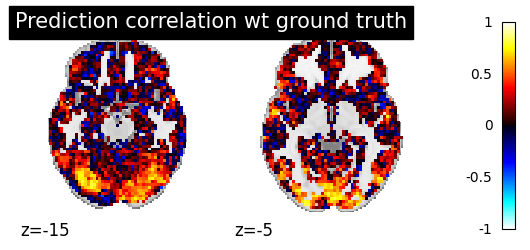

In [ ]:
# Now we use this scoring function to compare the correlation of predicted
# data with the real PA contrasts of sub-02.
aligned_score = masker.inverse_transform(score_voxelwise(
    target_test, target_pred, masker, loss='corr'))
display = plotting.plot_stat_map(
    aligned_score, display_mode="z", cut_coords=[-15, -5], vmax=1)
display.title("Prediction correlation wt ground truth")